<a href="https://colab.research.google.com/github/jhlee508/handson-ml2-study/blob/master/HoM_Ch15_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

# **15.3 시계열 예측하기**
시계열 데이터: 시간적 순서를 가지는 데이터(ex. 주식 가격, 날씨 데이터 등등)
- RNN 모델을 이용해 예측할 시계열을 임의로 만들어보자.

In [2]:
# 임의의 단변량 시계열 생성 함수
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1) # 랜덤 균등분포
    time = np.linspace(0, 1, n_steps) # 타입 스텝 길이의 직선
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   사인곡선(사인파) 1 
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + 사인곡선(사인파) 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + 잡음
    return series[..., np.newaxis].astype(np.float32)

(3, 10, 1)


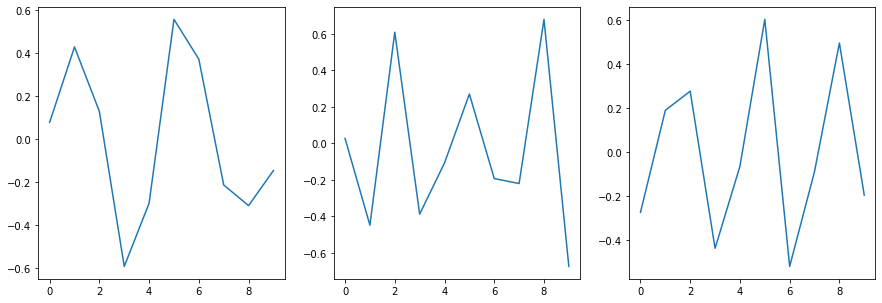

In [3]:
# 생성된 단변량 시계열 예시로 그려보기
batch_size_test = 3
time_step_test = 10

series_test = generate_time_series(batch_size_test, time_step_test)
print(series_test.shape)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    axes[i].plot(series_test[i, :, :])
plt.show()

In [4]:
n_steps = 50 # 타임 스텝 수 = 50

series = generate_time_series(10000, n_steps + 1) # 배치 크기 = 10000, 타임 스텝 수 = 50 + '1'
series.shape

(10000, 51, 1)

In [5]:
X_train, y_train = series[:7000, :n_steps], series[:7000, -1] # time_step = 50, time_step = 1
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [6]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

In [7]:
X_valid.shape, y_valid.shape

((2000, 50, 1), (2000, 1))

In [8]:
X_test.shape, y_test.shape

((1000, 50, 1), (1000, 1))

## **15.3.1 기준 성능(Baseline Performance)**
기준 성능을 준비해야 모델의 성능을 판단할 수 있다.

### 순진한(단순한) 예측

마지막 값을 예측, 실제(다음) 값과 비교



In [9]:
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.01976131

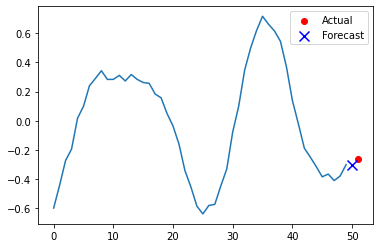

In [10]:
plt.plot(X_valid[0, :, 0]) # X_valid 첫 번째 시계열 데이터 그리기

plt.scatter(n_steps + 1, y_valid[0, 0], c = 'r', label="Actual") # 실제 값
plt.scatter(n_steps, y_pred[0, 0],marker = 'x', s = 100, c = 'b', label="Forecast") # y_valid 예측 값(마지막 값)
plt.legend(fontsize=10)
plt.show()

### 선형 회귀 모델 예측
- FC layer 네트워크

In [11]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])
model.compile(loss="mse", optimizer="adam")

model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 1s 4ms/step - loss: 0.2108 - val_loss: 0.0608
Epoch 2/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0537 - val_loss: 0.0333
Epoch 3/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0299 - val_loss: 0.0210
Epoch 4/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0186 - val_loss: 0.0150
Epoch 5/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0135 - val_loss: 0.0121
Epoch 6/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0111 - val_loss: 0.0104
Epoch 7/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0094 - val_loss: 0.0092
Epoch 8/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0085 - val_loss: 0.0082
Epoch 9/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0078 - val_loss: 0.0074
Epoch 10/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0070 - val_loss: 0.0068

In [12]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 1ms/step - loss: 0.0043


0.004329842049628496

## **15.3.2 간단한 RNN 구현하기**

### Simple RNN 모델
- 하나의 뉴런(하나의 층)으로 이루어진 RNN 모델
- tanh 활성화 함수 사용
- https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNN?version=nightly
- 모델 파라미터 = 3


In [13]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, return_sequences=False, input_shape=[None, 1]) # 입력 시퀀스 길이 지정 필요 없음!, 최종 출력만 반환!
])
print(model.summary())

model.compile(loss='mse', optimizer='adam')
model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
219/219 [==============================] - 3s 9ms/step - loss: 0.3024 - val_loss: 0.1884
Epoch 2/20
219/219 [==============================] - 2s 8ms/step - loss: 0.1659 - val_loss: 0.0847
Epoch 3/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0764 - val_loss: 0.0508
Epoch 4/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0516 - val_loss: 0.0426
Epoch 5/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0435 - val_loss: 0.0378
Epoch 6/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0382 - val_loss: 0.0339
Epoch 7/20
219/219 [=============================

In [14]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 3ms/step - loss: 0.0131


0.013134350068867207

### return_sequences 파라미터의 역할
- 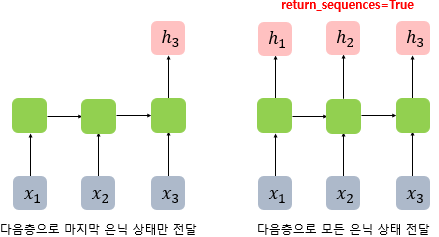
- 이미지 출처: https://wikidocs.net/22886

In [15]:
# return_sequence 파라미터의 역할
model = keras.models.Sequential()
model.add(keras.layers.SimpleRNN(1, input_shape=(3, 1), return_sequences=True)) # 타임 스텝 = 3
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 3, 1)              3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


## **15.3.3 Deep RNN**
- 셀을 여러 층으로 쌓은 심층 RNN 모델

In [16]:
# SimpleRNN(유닛 또는 은닉 상태의 크기 = 20)에서 '20'은 출력 차원의 수와 같다
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])
print(model.summary())

model.compile(loss="mse", optimizer="adam")
model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_2 (SimpleRNN)     (None, None, 20)          440       
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, None, 20)          820       
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, 1)                 22        
Total params: 1,282
Trainable params: 1,282
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
219/219 [==============================] - 9s 32ms/step - loss: 0.0749 - val_loss: 0.0143
Epoch 2/20
219/219 [==============================] - 6s 29ms/step - loss: 0.0102 - val_loss: 0.0073
Epoch 3/20
219/219 [==============================] - 6s 29ms/step - loss: 0.0063 - val_loss: 0.0056
Epoch 4/20
219/219 [==============================] - 6s 28ms/step - loss:

In [17]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 7ms/step - loss: 0.0032


0.003166179871186614

### 마지막 층의 은닉 상태 제거
하나의 값만 출력하면 된다! 마지막 층에서 굳이 순환할 필요는 없다!
- Dense Layer 사용
- 새로운 활성화 함수 사용 가능
- 정확도도 조금 더 좋고 속도 또한 훨씬 빠르다.

In [18]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20), # return_sequences 제거 -> 은닉 상태 제거
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 6s 22ms/step - loss: 0.0249 - val_loss: 0.0046
Epoch 2/20
219/219 [==============================] - 4s 20ms/step - loss: 0.0044 - val_loss: 0.0042
Epoch 3/20
219/219 [==============================] - 4s 20ms/step - loss: 0.0039 - val_loss: 0.0038
Epoch 4/20
219/219 [==============================] - 4s 20ms/step - loss: 0.0034 - val_loss: 0.0031
Epoch 5/20
219/219 [==============================] - 4s 21ms/step - loss: 0.0033 - val_loss: 0.0036
Epoch 6/20
219/219 [==============================] - 5s 21ms/step - loss: 0.0034 - val_loss: 0.0031
Epoch 7/20
219/219 [==============================] - 4s 20ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 8/20
219/219 [==============================] - 4s 20ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 9/20
219/219 [==============================] - 4s 20ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 10/20
219/219 [==============================] - 4s 20ms/step - loss: 0.0029 - val_lo

In [19]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 6ms/step - loss: 0.0026


0.00258278613910079

## **15.3.4 여러 타임 스텝 앞을 예측하기**

### 방법 1) 한 번에 1 스텝 씩 10 스텝 앞을 예측하기

In [20]:
series = generate_time_series(1, n_steps + 10) # 타임 스텝 = 50 + 10 = 60

# 새로운 X, Y 생성
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new

In [21]:
# 하나의 값을 예측하는 모델로 하나의 값씩 총 10개 예측
# 1~50일 -> 51일 예측, 2~51일 -> 52일 예측 ...... 10~59일 -> 60일 예측 
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]

In [22]:
Y_pred

array([[[-0.01558931],
        [ 0.0771711 ],
        [ 0.1899021 ],
        [ 0.2943218 ],
        [ 0.3962233 ],
        [ 0.50437415],
        [ 0.5837855 ],
        [ 0.5915876 ],
        [ 0.5147392 ],
        [ 0.3811371 ]]], dtype=float32)

In [23]:
np.mean(keras.metrics.mean_squared_error(Y_new, Y_pred))

0.054120697

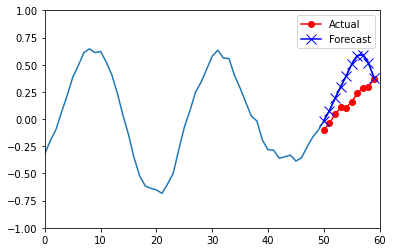

In [24]:
plt.plot(X[0, :, 0])
plt.plot(np.arange(n_steps, n_steps + 10), Y_new[0, :, 0], "ro-", label="Actual")
plt.plot(np.arange(n_steps, n_steps + 10), Y_pred[0, :, 0], "bx-", label="Forecast", markersize=10)
plt.axis([0, n_steps + 10, -1, 1])
plt.legend(fontsize=10)
plt.show()

### 방법 2) 다음 값 10개를 한 번에 예측
- 50개의 타임 스텝을 이용하여 다음 10개의 타임 스텝 값 예측
- 타깃 = 10개의 타임 스텝 값을 지닌 벡터
-  0 ~ 49  =>  50 ~ 59 

In [25]:
n_steps = 50

series = generate_time_series(10000, n_steps + 10) # 타임 스텝 = 50 + 10

X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0] # Y 타깃을 마지막 10개의 값으로 설정
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

In [26]:
X_train.shape, Y_train.shape

((7000, 50, 1), (7000, 10))

In [27]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 6s 22ms/step - loss: 0.0861 - val_loss: 0.0306
Epoch 2/20
219/219 [==============================] - 4s 20ms/step - loss: 0.0280 - val_loss: 0.0214
Epoch 3/20
219/219 [==============================] - 4s 20ms/step - loss: 0.0194 - val_loss: 0.0174
Epoch 4/20
219/219 [==============================] - 4s 20ms/step - loss: 0.0164 - val_loss: 0.0172
Epoch 5/20
219/219 [==============================] - 4s 20ms/step - loss: 0.0163 - val_loss: 0.0138
Epoch 6/20
219/219 [==============================] - 4s 20ms/step - loss: 0.0137 - val_loss: 0.0125
Epoch 7/20
219/219 [==============================] - 4s 20ms/step - loss: 0.0132 - val_loss: 0.0119
Epoch 8/20
219/219 [==============================] - 4s 20ms/step - loss: 0.0124 - val_loss: 0.0116
Epoch 9/20
219/219 [==============================] - 5s 21ms/step - loss: 0.0119 - val_loss: 0.0110
Epoch 10/20
219/219 [==============================] - 4s 20ms/step - loss: 0.0117 - val_lo

In [28]:
model.evaluate(X_test, Y_test)

32/32 [==============================] - 0s 6ms/step - loss: 0.0085


0.008520744740962982

### 방법 3) 모든 타임 스텝에서 다음 값 10개 예측하기
- 시퀀스-TO-시퀀스 RNN으로 변경
- 타임 스텝 0  =>  1 ~ 10
- 타임 스텝 1  =>  2 ~ 11
- 타임 스텝 2  =>  3 ~ 12
- ......
- 타임 스텝 49 => 50 ~ 59

In [29]:
n_steps = 50

series = generate_time_series(10000, n_steps + 10) # 60 타임 스텝

X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]

X_train.shape

(7000, 50, 1)

In [30]:
Y = np.empty((10000, n_steps, 10))

# 타임 스텝 0  =>  1 ~ 10 ......
for step_ahead in range(1, 10 + 1):
    Y[:, :, step_ahead - 1] = series[:, step_ahead:step_ahead + n_steps, 0]
    
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

Y_train.shape

(7000, 50, 10)

In [31]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True), # return_sequences 추가 => 시퀀스 to 시퀀스 모델
    keras.layers.TimeDistributed(keras.layers.Dense(10)) # 모든 타임 스텝에서 출력을 적용하기 위해 사용
])

# 마지막 타임 스텝의 출력에 대한 MSE만 사용
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model.compile(loss="mse", optimizer=keras.optimizers.Adam(lr=0.01), metrics=[last_time_step_mse])
model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 7s 23ms/step - loss: 0.0796 - last_time_step_mse: 0.0692 - val_loss: 0.0408 - val_last_time_step_mse: 0.0290
Epoch 2/20
219/219 [==============================] - 4s 20ms/step - loss: 0.0388 - last_time_step_mse: 0.0253 - val_loss: 0.0341 - val_last_time_step_mse: 0.0215
Epoch 3/20
219/219 [==============================] - 5s 21ms/step - loss: 0.0345 - last_time_step_mse: 0.0218 - val_loss: 0.0310 - val_last_time_step_mse: 0.0184
Epoch 4/20
219/219 [==============================] - 5s 21ms/step - loss: 0.0297 - last_time_step_mse: 0.0171 - val_loss: 0.0279 - val_last_time_step_mse: 0.0161
Epoch 5/20
219/219 [==============================] - 5s 21ms/step - loss: 0.0282 - last_time_step_mse: 0.0163 - val_loss: 0.0233 - val_last_time_step_mse: 0.0116
Epoch 6/20
219/219 [==============================] - 5s 21ms/step - loss: 0.0239 - last_time_step_mse: 0.0111 - val_loss: 0.0215 - val_last_time_step_mse: 0.0097
Epoch 7/20
219/219 [==

In [32]:
model.evaluate(X_test, Y_test)

32/32 [==============================] - 0s 6ms/step - loss: 0.0173 - last_time_step_mse: 0.0058


[0.017319122329354286, 0.00581240514293313]

# 15.4 긴 시퀀스 다루기
- 타임 스텝 증가 -> 매우 깊은 네트워크

- 문제 1: 그래디언트 소실 & 폭주 
- 문제 2: 장기 기억 불가

## 15.4.1 불안정한 그레이디언트 문제와 싸우기
- 수렴하지 않는 활성화 함수(ex. ReLU)는 오히려 성능 악화
- 배치 정규화 -> 성능 그저 그렇다.
- 층 정규화 -> 효과적이다.

### 배치 정규화 층

In [33]:
# 순환 층 사이에 배치 정규화 층 추가하기, 타임 스텝 사이에는???
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.BatchNormalization(), # 배치정규화 층 추가
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.BatchNormalization(), # 배치정규화 층 추가
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 8s 25ms/step - loss: 0.1852 - last_time_step_mse: 0.1715 - val_loss: 0.0711 - val_last_time_step_mse: 0.0658
Epoch 2/20
219/219 [==============================] - 5s 23ms/step - loss: 0.0501 - last_time_step_mse: 0.0419 - val_loss: 0.0470 - val_last_time_step_mse: 0.0389
Epoch 3/20
219/219 [==============================] - 5s 23ms/step - loss: 0.0425 - last_time_step_mse: 0.0323 - val_loss: 0.0402 - val_last_time_step_mse: 0.0290
Epoch 4/20
219/219 [==============================] - 5s 23ms/step - loss: 0.0376 - last_time_step_mse: 0.0265 - val_loss: 0.0363 - val_last_time_step_mse: 0.0256
Epoch 5/20
219/219 [==============================] - 5s 23ms/step - loss: 0.0345 - last_time_step_mse: 0.0232 - val_loss: 0.0352 - val_last_time_step_mse: 0.0230
Epoch 6/20
219/219 [==============================] - 5s 23ms/step - loss: 0.0329 - last_time_step_mse: 0.0208 - val_loss: 0.0330 - val_last_time_step_mse: 0.0206
Epoch 7/20
219/219 [==

In [34]:
model.evaluate(X_test, Y_test)

32/32 [==============================] - 0s 6ms/step - loss: 0.0271 - last_time_step_mse: 0.0154


[0.027129702270030975, 0.015353296883404255]

### 층 정규화
- 특성 차원에 대한 정규화
- 메모리 셀 안에 층 정규화 
- 타임 스텝(순환 층 내부, 즉 수평 방향)마다 적용
- 속도는 아무래도 느리다...

In [35]:
from tensorflow.keras.layers import LayerNormalization

In [36]:
class LNSimpleRNNCell(keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units # 은닉 상태
        self.output_size = units # 출력 상태
        self.simple_rnn_cell = keras.layers.SimpleRNNCell(units, activation=None) # 활성화 함수 삭제
        self.layer_norm = LayerNormalization() # 내부에서 층 정규화
        self.activation = keras.activations.get(activation) # 활성화 함수 적추가
    
    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs)) # 층 정규화 + 활성화 함수 적용
        return norm_outputs, [norm_outputs]

In [37]:
model = keras.models.Sequential([
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True, input_shape=[None, 1]),
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 13s 48ms/step - loss: 0.2754 - last_time_step_mse: 0.2660 - val_loss: 0.0696 - val_last_time_step_mse: 0.0596
Epoch 2/20
219/219 [==============================] - 10s 46ms/step - loss: 0.0634 - last_time_step_mse: 0.0514 - val_loss: 0.0525 - val_last_time_step_mse: 0.0407
Epoch 3/20
219/219 [==============================] - 10s 46ms/step - loss: 0.0518 - last_time_step_mse: 0.0389 - val_loss: 0.0476 - val_last_time_step_mse: 0.0346
Epoch 4/20
219/219 [==============================] - 10s 46ms/step - loss: 0.0459 - last_time_step_mse: 0.0327 - val_loss: 0.0419 - val_last_time_step_mse: 0.0276
Epoch 5/20
219/219 [==============================] - 10s 46ms/step - loss: 0.0402 - last_time_step_mse: 0.0246 - val_loss: 0.0380 - val_last_time_step_mse: 0.0231
Epoch 6/20
219/219 [==============================] - 10s 46ms/step - loss: 0.0376 - last_time_step_mse: 0.0225 - val_loss: 0.0352 - val_last_time_step_mse: 0.0194
Epoch 7/20
219/2

In [38]:
model.evaluate(X_test, Y_test)

32/32 [==============================] - 0s 11ms/step - loss: 0.0258 - last_time_step_mse: 0.0110


[0.025798318907618523, 0.011046510189771652]

## 15.4.2 단기 기억 문제 해결하기
- 장기 메모리를 가진 여러 종류의 셀(LSTM, GRU)


### LSTM(Long Short-Term Memory) 셀
- 장기 상태에 저장할 것, 버릴 것, 읽어들일 것을 학습하는 셀
- 장기 상태에 저장, 보존, 추출
- 장기 패턴 파악에 효과적

In [39]:
model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 15s 48ms/step - loss: 0.1013 - last_time_step_mse: 0.0909 - val_loss: 0.0507 - val_last_time_step_mse: 0.0308
Epoch 2/20
219/219 [==============================] - 10s 44ms/step - loss: 0.0461 - last_time_step_mse: 0.0257 - val_loss: 0.0386 - val_last_time_step_mse: 0.0177
Epoch 3/20
219/219 [==============================] - 9s 43ms/step - loss: 0.0376 - last_time_step_mse: 0.0174 - val_loss: 0.0347 - val_last_time_step_mse: 0.0147
Epoch 4/20
219/219 [==============================] - 9s 43ms/step - loss: 0.0343 - last_time_step_mse: 0.0148 - val_loss: 0.0323 - val_last_time_step_mse: 0.0138
Epoch 5/20
219/219 [==============================] - 10s 43ms/step - loss: 0.0318 - last_time_step_mse: 0.0137 - val_loss: 0.0307 - val_last_time_step_mse: 0.0122
Epoch 6/20
219/219 [==============================] - 10s 43ms/step - loss: 0.0302 - last_time_step_mse: 0.0122 - val_loss: 0.0291 - val_last_time_step_mse: 0.0110
Epoch 7/20
219/219

In [40]:
model.evaluate(X_test, Y_test)

32/32 [==============================] - 0s 11ms/step - loss: 0.0222 - last_time_step_mse: 0.0063


[0.022169379517436028, 0.0062904381193220615]

### GRU(Gate Recurrent Unit) 셀
- LSTM 변종
- 간소화된 버전

In [41]:
model = keras.models.Sequential([
    keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 15s 51ms/step - loss: 0.0974 - last_time_step_mse: 0.0914 - val_loss: 0.0544 - val_last_time_step_mse: 0.0428
Epoch 2/20
219/219 [==============================] - 10s 47ms/step - loss: 0.0508 - last_time_step_mse: 0.0403 - val_loss: 0.0451 - val_last_time_step_mse: 0.0338
Epoch 3/20
219/219 [==============================] - 10s 48ms/step - loss: 0.0446 - last_time_step_mse: 0.0343 - val_loss: 0.0417 - val_last_time_step_mse: 0.0301
Epoch 4/20
219/219 [==============================] - 10s 47ms/step - loss: 0.0408 - last_time_step_mse: 0.0293 - val_loss: 0.0382 - val_last_time_step_mse: 0.0257
Epoch 5/20
219/219 [==============================] - 10s 47ms/step - loss: 0.0371 - last_time_step_mse: 0.0252 - val_loss: 0.0342 - val_last_time_step_mse: 0.0209
Epoch 6/20
219/219 [==============================] - 10s 47ms/step - loss: 0.0329 - last_time_step_mse: 0.0198 - val_loss: 0.0301 - val_last_time_step_mse: 0.0157
Epoch 7/20
219/2

In [42]:
model.evaluate(X_test, Y_test)

32/32 [==============================] - 0s 10ms/step - loss: 0.0227 - last_time_step_mse: 0.0091


[0.02271309308707714, 0.009093258529901505]

### 1D 합성곱 층을 사용해 시퀀스 처리하기
- 여전히 긴 길이의 데이터에 대해서 기억하지 못하는 문제점 존재
- 입력 시퀀스를 짧게 줄이기 위해 1D 합성곱 사용

In [43]:
model = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding="valid", input_shape=[None, 1]), # 커널 크기 = 4, 스트라이드 = 2
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])
model.summary()

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
model.fit(X_train, Y_train[:, 3::2], epochs=20, validation_data=(X_valid, Y_valid[:, 3::2])) # 타깃을 3부터 시작,  2배 다운샘플링

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 20)          100       
_________________________________________________________________
gru_2 (GRU)                  (None, None, 20)          2520      
_________________________________________________________________
gru_3 (GRU)                  (None, None, 20)          2520      
_________________________________________________________________
time_distributed_5 (TimeDist (None, None, 10)          210       
Total params: 5,350
Trainable params: 5,350
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
219/219 [==============================] - 11s 31ms/step - loss: 0.0923 - last_time_step_mse: 0.0855 - val_loss: 0.0467 - val_last_time_step_mse: 0.0381
Epoch 2/20
219/219 [==============================] - 6s 26ms/step - loss: 0.0433 - l

In [44]:
model.evaluate(X_test, Y_test[:, 3::2])

32/32 [==============================] - 0s 6ms/step - loss: 0.0184 - last_time_step_mse: 0.0085


[0.018404286354780197, 0.00845030602067709]

In [45]:
# 리스트[::] 기능
x = [i for i in range(10)]
x[3::2]

[3, 5, 7, 9]

### WAVENET
- 음성을 고품질로 합성해내기 위한 모델
- 층마다 팽창 비율을 두 배로 늘리는 1D 합성곱 층
- 하위층은 단기 패턴, 상위층은 장기 패턴
- 여러 오디오 문제에서 최상의 성능 보임
- 'Causal' Padding : https://stackoverflow.com/questions/52578950/causal-padding-in-keras

In [46]:
model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for rate in (1, 2, 4, 8) * 2:
    model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=rate)) # 팽창비율
model.add(keras.layers.Conv1D(filters=10, kernel_size=1))
model.summary()

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, None, 20)          60        
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 20)          820       
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 20)          820       
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 20)          820       
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 20)          820       
_________________________________________________________________
conv1d_6 (Conv1D)            (None, None, 20)          820       
_________________________________________________________________
conv1d_7 (Conv1D)            (None, None, 20)        

In [47]:
model.evaluate(X_test, Y_test)

32/32 [==============================] - 0s 6ms/step - loss: 0.0188 - last_time_step_mse: 0.0068


[0.018773432821035385, 0.006771696265786886]